# Full Photometry Pipeline

This tutorial demonstrates how to run the end--to--end photometry pipeline on
real JWST data included with *Mophongo*. We build templates from the F444W
mosaic and fit fluxes in the F770W image using spatially varying PSF
matching kernels.

## Detect sources in F444W

In [1]:
from pathlib import Path
import numpy as np
from astropy.io import fits

data_dir = Path('../data')
field = 'uds-test'
#field = 'uds-medium'
#field = 'uds-large'
sci_444 = data_dir / f'{field}-f444w_sci.fits'
wht_444 = data_dir / f'{field}-f444w_wht.fits'


## Build PSF region map

/Users/ivo/Astro/PROJECTS/MOPHONGO/mophongo/mophongo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm




The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


geometry  psf_key_1  psf_key_2  \
0   POLYGON ((34.30361 -5.10681, 34.30431 -5.10875...          0          1   
1   POLYGON ((34.30556 -5.10681, 34.30583 -5.10736...          1          0   
2   POLYGON ((34.30361 -5.10681, 34.30472 -5.10681...          1          1   
3   POLYGON ((34.29764 -5.11472, 34.29764 -5.10681...          2          1   
4   POLYGON ((34.3025 -5.11042, 34.30361 -5.11292,...          3          1   
5   POLYGON ((34.30361 -5.11292, 34.30444 -5.11472...          4          1   
6   POLYGON ((34.30431 -5.10875, 34.30528 -5.11139...          5          1   
7   POLYGON ((34.30431 -5.11472, 34.30444 -5.11472...          6          1   
8   POLYGON ((34.30681 -5.11, 34.30806 -5.11333, 3...          7          0   
9   POLYGON ((34.30583 -5.11083, 34.30667 -5.11389...          7          1   
10  POLYGON ((34.30583 -5.10736, 34.30597 -5.10722...          8          0   
11  POLYGON ((34.305 -5.10806, 34.30583 -5.11083, ...          8          1   
12  POLYGON ((34.30583 -5.10736, 34.30569 -5.10681...          9          0   
13  MULTIPOLYGON (((34.30806 -5.11333, 34.30819 -5...         10          0   
14  POLYGON ((34.30625 -5.11403, 34.30667 -5.11389...         10          1   
15  POLYGON ((34.30875 -5.11361, 34.30875 -5.11583...         11          0   
16  POLYGON ((34.30667 -5.11542, 34.30708 -5.11514...         11          1   
17  POLYGON ((34.30472 -5.11583, 34.30264 -5.11583...         12          1   
18  POLYGON ((34.30458 -5.11514, 34.30597 -5.11472...         13          1   
19  MULTIPOLYGON (((34.30653 -5.11583, 34.30625 -5...         14          1   
20  POLYGON ((34.30819 -5.11389, 34.30806 -5.11333...         15          0   
21  POLYGON ((34.30681 -5.11431, 34.30708 -5.11514...         15          1   
22  POLYGON ((34.30764 -5.10681, 34.30875 -5.10681...         16          0   
23  POLYGON ((34.30861 -5.10833, 34.30875 -5.10819...         17          0   
24  POLYGON ((34.30764 -5.10681, 34.30861 -5.10833...         18          0   
25  POLYGON ((34.30444 -5.11472, 34.30583 -5.11417...         19          1   

    psf_key  
0         0  
1         1  
2         2  
3         3  
4         4  
5         5  
6         6  
7         7  
8         8  
9         9  
10       10  
11       11  
12       12  
13       13  
14       14  
15       15  
16       16  
17       17  
18       18  
19       19  
20       20  
21       21  
22       22  
23       23  
24       24  
25       25

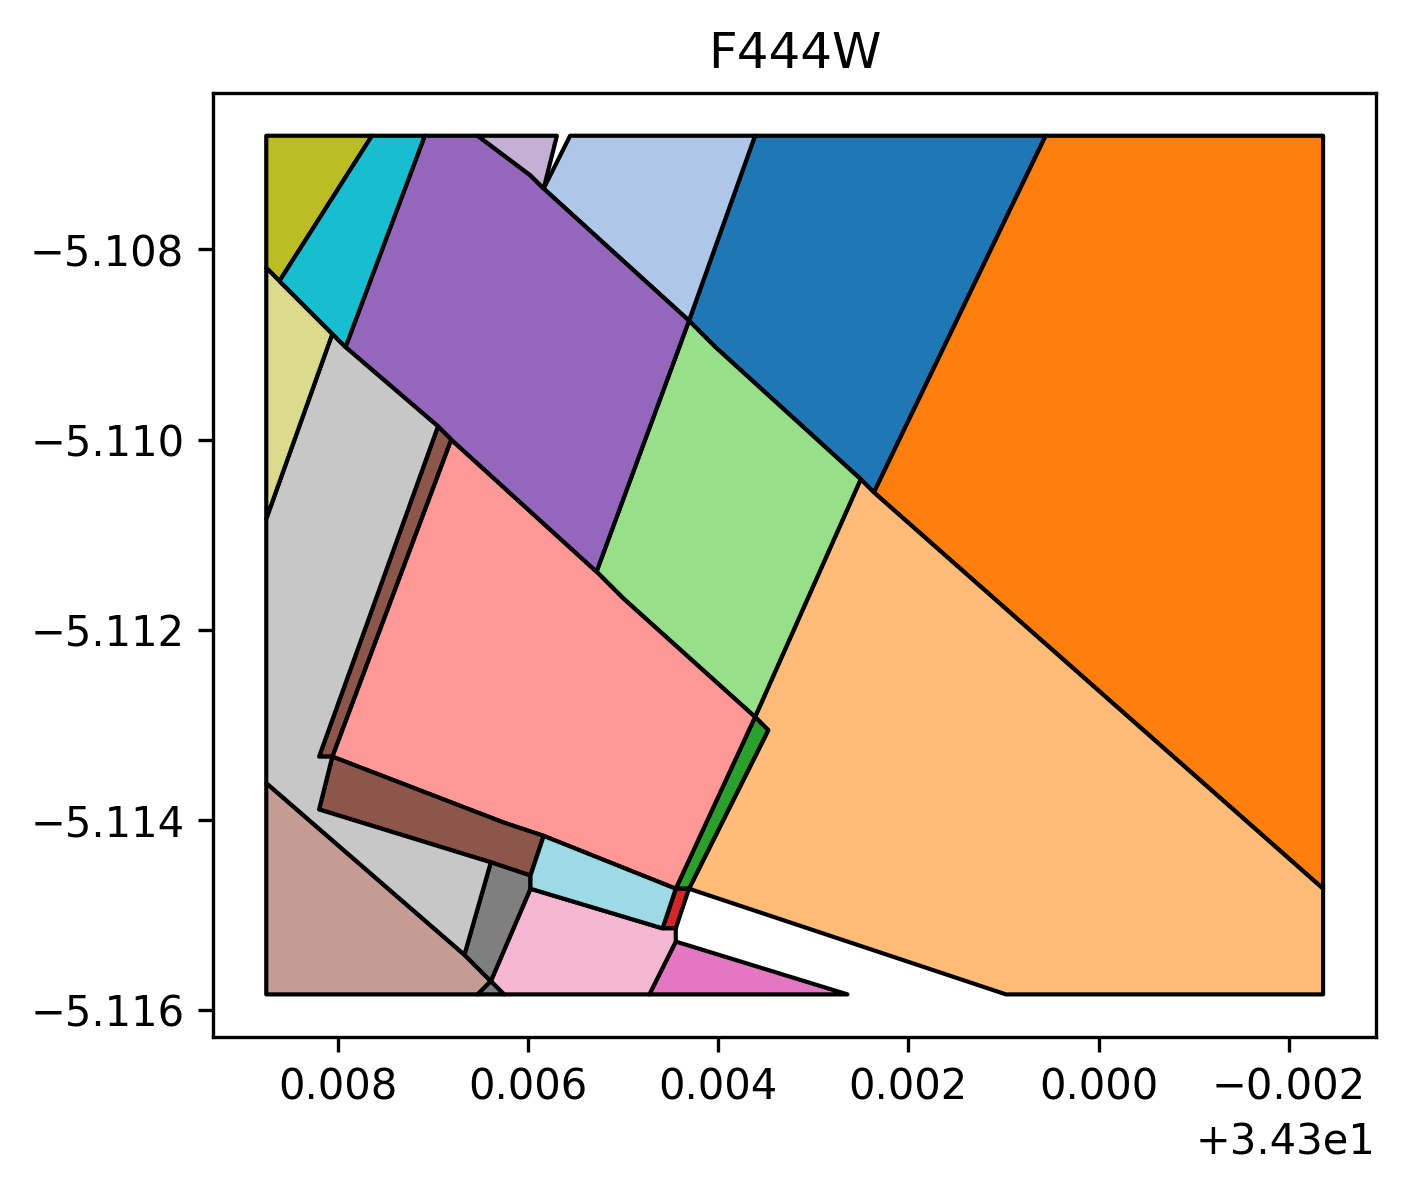

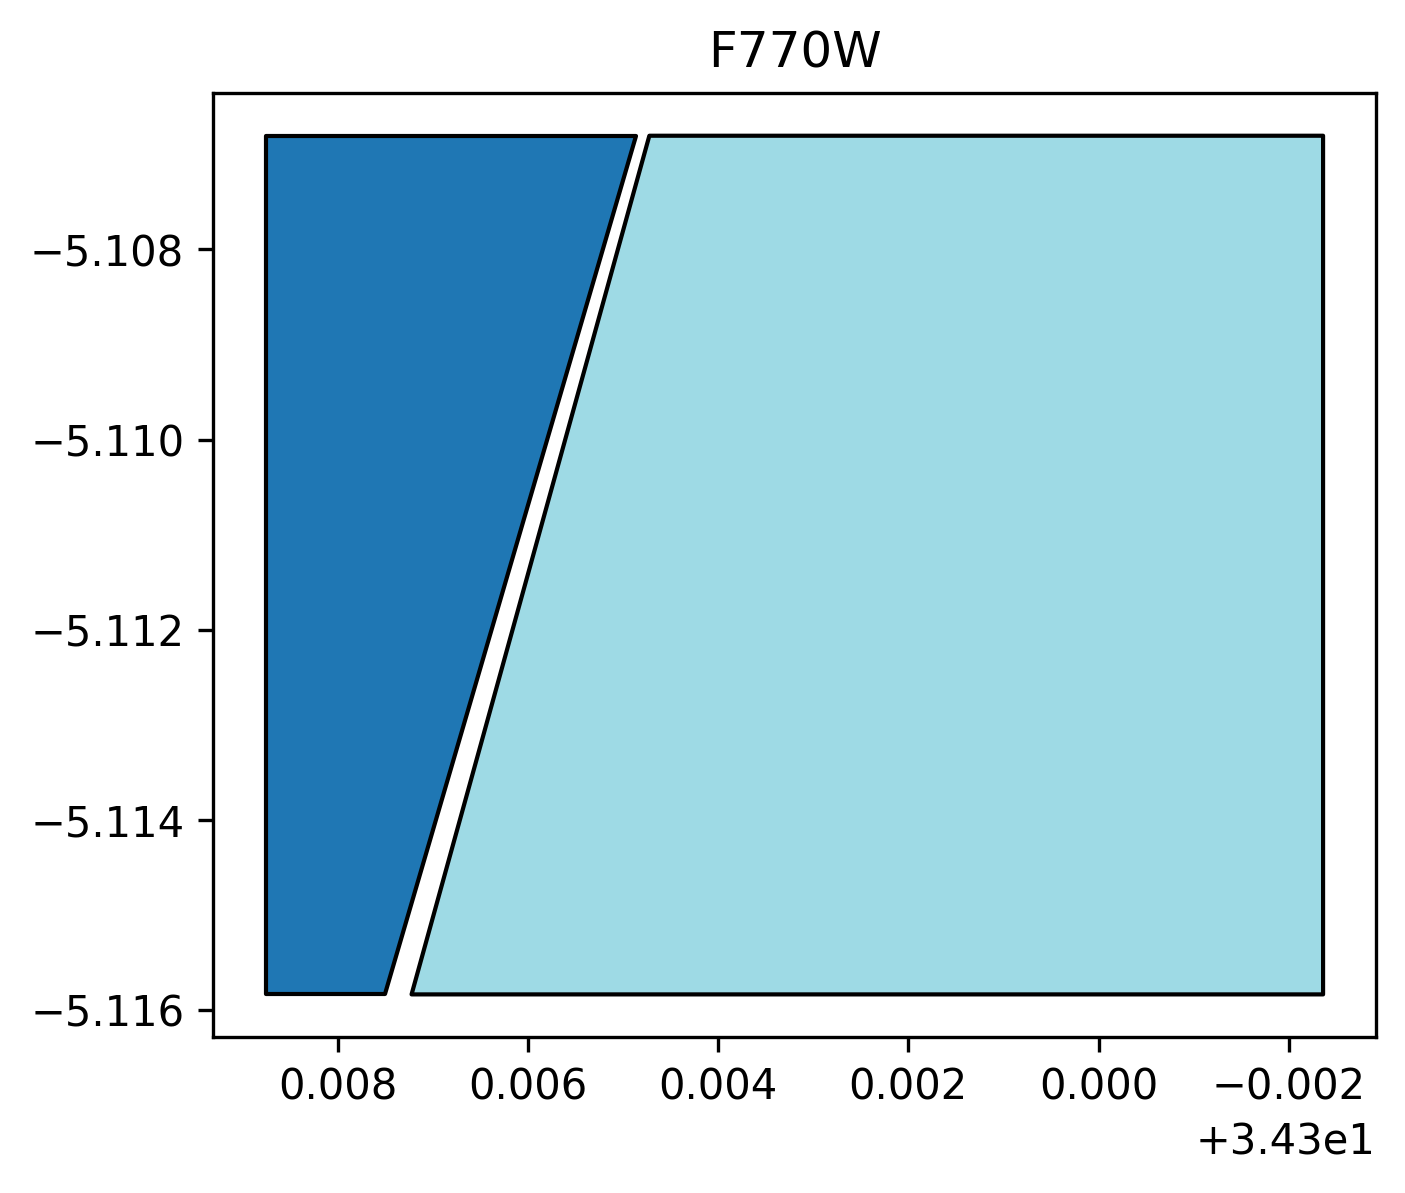

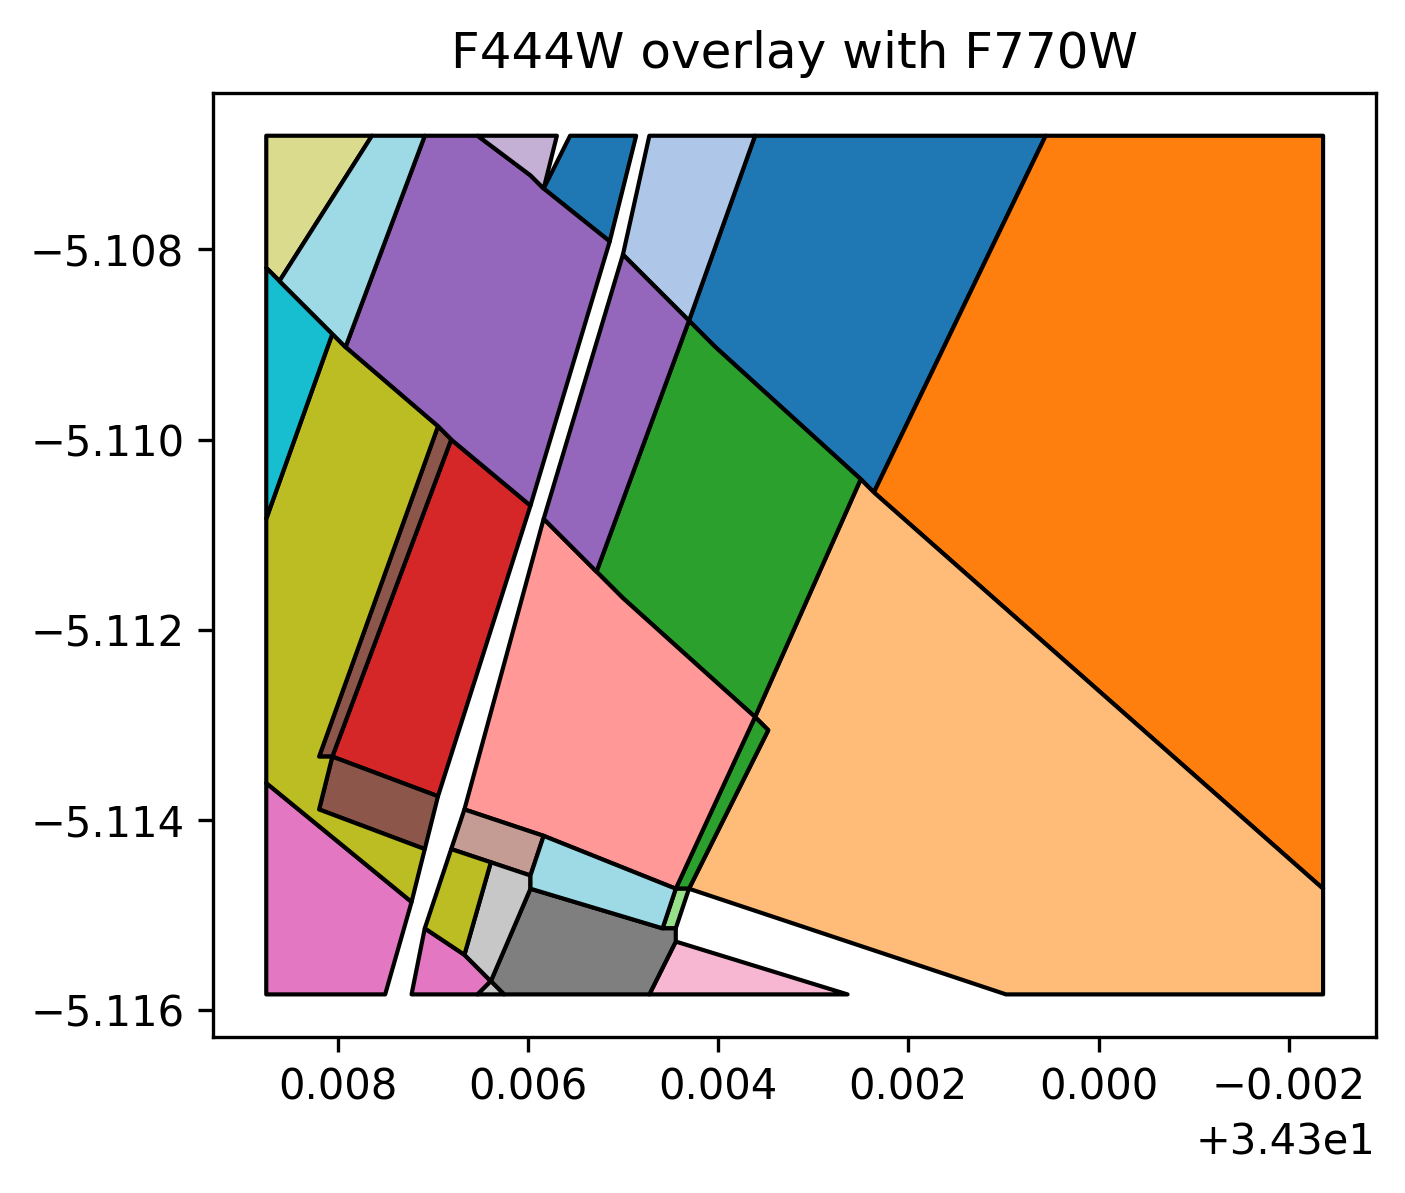

In [2]:
from mophongo.psf import DrizzlePSF
from mophongo.psf_map import PSFRegionMap

# initialize drizzler; also reads the associated _wcs.csv files (rate files wcs/header information)
dpsf_444 = DrizzlePSF(driz_image=str(sci_444))
dpsf_770 = DrizzlePSF(driz_image=str(sci_444).replace('444', '770'))

# map unique detector overlaps; keep only footprints overlapping the target mosaic
prm_444 = PSFRegionMap.from_footprints(dpsf_444.footprint, name='F444W').overlay_with(dpsf_444.driz_footprint)
prm_770 = PSFRegionMap.from_footprints(dpsf_770.footprint, name='F770W').overlay_with(dpsf_444.driz_footprint)

# compute overlay regions unique to both PSFs
prm_kern = prm_444.overlay_with(prm_770)
prm_444.plot()
prm_770.plot()
prm_kern.plot()
prm_kern.regions

## Create PSF kernels

In [3]:
import mophongo.utils as utils

psf_dir = data_dir / 'PSF'
stpsf_444 = 'UDS_NRC.._F444W_OS4_GRID25'
stpsf_770 = 'UDS_MIRI_F770W_OS4_GRID9'
size = 101

# centroid positions of the regions
pos = [np.squeeze(p.xy) for p in prm_kern.regions.geometry.centroid]

# load webb psfs
dpsf_444.epsf_obj.load_jwst_stdpsf(local_dir=str(psf_dir), filter_pattern=stpsf_444)
dpsf_770.epsf_obj.load_jwst_stdpsf(local_dir=str(psf_dir), filter_pattern=stpsf_770)

# drizzle at centroid positions
prm_444.psfs = dpsf_444.get_psf_radec(pos, size=size)
prm_770.psfs = dpsf_770.get_psf_radec(pos, size=size)

# store the PSFs + region maps
prm_444.to_file(data_dir / f'{field}-f444w_psf.geojson')
prm_770.to_file(data_dir / f'{field}-f770w_psf.geojson')

# match kernels
# @@@ need a better way to determine best fft window shape
kernels = [utils.matching_kernel(psf_444, psf_770, recenter=True) for psf_444, psf_770 in zip(prm_444.psfs, prm_770.psfs)]

prm_kern.psfs = np.asarray(kernels)
prm_kern.to_file(data_dir / f'{field}-f444w_kernel_f770w.geojson')

Drizzling PSFs: 100%|██████████| 26/26 [00:00<00:00, 67.28it/s]


## Run photometry

In [1]:
from pathlib import Path
from astropy.io import fits
from mophongo.psf_map import PSFRegionMap
from mophongo.fit import FitConfig
from mophongo.catalog import Catalog
from mophongo import pipeline

data_dir = Path('../data')
field = 'uds-test'
#field = 'uds-medium'
#field = 'uds-large'
sci_444 = data_dir / f'{field}-f444w_sci.fits'
wht_444 = data_dir / f'{field}-f444w_wht.fits'

prm_kern = PSFRegionMap.from_geojson(str(data_dir / f'{field}-f444w_kernel_f770w.geojson'))
prm_444 = PSFRegionMap.from_geojson(str(data_dir / f'{field}-f444w_psf.geojson'))
prm_770 = PSFRegionMap.from_geojson(str(data_dir / f'{field}-f770w_psf.geojson'))

# MIRI images
img_770 = fits.getdata(data_dir / f'{field}-f770w_sci.fits')
wht_770 = fits.getdata(data_dir / f'{field}-f770w_wht.fits')

# read in LW selected catalog
seg_LW = data_dir / f'{field}-LW_seg.fits'
cat444 = Catalog.from_fits(sci_444, wht_444, segmap=seg_LW, estimate_ivar=True)
cat770 = Catalog.from_fits(img_770, wht_770, segmap=seg_LW, estimate_ivar=True) 

residual = [None, None, None, None]


/Users/ivo/Astro/PROJECTS/MOPHONGO/mophongo/mophongo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Measuring inverse variance map...
Measuring inverse variance map...


/Users/ivo/Astro/PROJECTS/MOPHONGO/mophongo/mophongo/src/mophongo/catalog.py:411: RuntimeWarning: divide by zero encountered in divide
  error=np.sqrt(1.0 / self.ivar),


In [2]:
# first fit, no shifts: first image is template, 2nd and on the fitting images
table, res, fit = pipeline.run([cat444.sci, cat770.sci], cat444.segmap.data,
                                weights=[cat444.ivar, cat770.ivar],
                                catalog=cat444.table,
                                psfs=[prm_444, prm_770],
                                kernels=[None, prm_kern],
                                wcs=[cat444.wcs]* 2,
                                config=FitConfig(fit_astrometry_niter=0, solve_method = 'ata'))
residual[0] = res[0]
fits.writeto('residual_noshift.fits', data=residual[0], overwrite=True)
fits.writeto('model_noshift.fits', data=cat770.sci-residual[0], overwrite=True)



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Pipeline (start) memory: 0.5 GB
Pipeline config: FitConfig(positivity=False, reg=0.0, bad_value=nan, solve_method='ata', cg_kwargs={'M': None, 'maxiter': 500, 'atol': 1e-06}, fit_covariances=False, fft_fast=False, fit_astrometry_niter=0, fit_astrometry_joint=False, reg_astrom=0.0001, snr_thresh_astrom=10.0, astrom_model='gp', astrom_centroid='centroid', astrom_kwargs={'poly': {'order': 2}, 'gp': {'length_scale': 500}}, multi_tmpl_chi2_thresh=5.0, multi_tmpl_psf_core=True, mult

Extracting templates: 100%|██████████| 384/384 [00:00<00:00, 2252.12it/s]


Pipepline: 382 extracted templates, dropped 2.
Pipeline (templates) memory: 0.5 GB
binning factor: 1
Using kernel lookup table uds-test-f444w_kernel_f770w


Convolving templates: 100%|██████████| 382/382 [00:00<00:00, 2118.20it/s]


Pipeline (convolved) memory: 0.5 GB
Running iteration 1 of 1


Building Normal matrix: 100%|██████████| 382/382 [00:00<00:00, 21410.09it/s]


Pipeline (residual) memory: 0.5 GB


Building Normal matrix: 100%|██████████| 382/382 [00:00<00:00, 16405.31it/s]


Distribution >99% chi2: [9.3548111]
Adding 5 new templates for poor fits (chi^2/nu > 5.0)


Building Normal matrix: 100%|██████████| 387/387 [00:00<00:00, 18896.34it/s]


Done...
Pipeline (end) memory: 0.5 GB


### Separate flux and astrometric fit

First fit fluxes, then astrometric shift field, iterate.

In [3]:
# test astrometry fit vs number of iterations for separate astro + flux fits
config = FitConfig(fit_astrometry_niter=3, fit_astrometry_joint=False)
table1, res1, fit1 = pipeline.run([cat444.sci, cat770.sci],
                                cat444.segmap.data,
                                weights=[cat444.ivar, cat770.ivar],
                                catalog=cat444.table,  
                                psfs=[prm_444, prm_770],
                                kernels=[None, prm_kern],
                                wcs=[cat444.wcs] * 2,
                                config=config)
residual[1] = res1[0]
fits.writeto('residual_separate.fits', data=residual[1], overwrite=True)
fits.writeto('model_separate.fits', data=cat770.sci-residual[1], overwrite=True)

Pipeline (start) memory: 0.5 GB
Pipeline config: FitConfig(positivity=False, reg=0.0, bad_value=nan, solve_method='ata', cg_kwargs={'M': None, 'maxiter': 500, 'atol': 1e-06}, fit_covariances=False, fft_fast=False, fit_astrometry_niter=3, fit_astrometry_joint=False, reg_astrom=0.0001, snr_thresh_astrom=10.0, astrom_model='gp', astrom_centroid='centroid', astrom_kwargs={'poly': {'order': 2}, 'gp': {'length_scale': 500}}, multi_tmpl_chi2_thresh=5.0, multi_tmpl_psf_core=True, multi_tmpl_colour=False, normal='tree')


Extracting templates: 100%|██████████| 384/384 [00:00<00:00, 3392.89it/s]


Pipepline: 382 extracted templates, dropped 2.
Pipeline (templates) memory: 0.5 GB
binning factor: 1
Using kernel lookup table uds-test-f444w_kernel_f770w


Convolving templates: 100%|██████████| 382/382 [00:00<00:00, 1988.62it/s]

Pipeline (convolved) memory: 0.6 GB


Running iteration 1 of 3


Building Normal matrix: 100%|██████████| 382/382 [00:00<00:00, 15021.65it/s]


Pipeline (residual) memory: 0.6 GB
Running iteration 2 of 3


Building Normal matrix: 100%|██████████| 382/382 [00:00<00:00, 23712.41it/s]

Pipeline (residual) memory: 0.6 GB


Running iteration 3 of 3


Building Normal matrix: 100%|██████████| 382/382 [00:00<00:00, 26973.02it/s]

Pipeline (residual) memory: 0.6 GB



Building Normal matrix: 100%|██████████| 382/382 [00:00<00:00, 27848.78it/s]


Distribution >99% chi2: [2.30215436]
Adding 4 new templates for poor fits (chi^2/nu > 5.0)


Building Normal matrix: 100%|██████████| 386/386 [00:00<00:00, 25166.35it/s]


Done...
Pipeline (end) memory: 0.6 GB


###  Joint photometric and astrometric fit

Append Cheby polynomial coefficients to sparse matrix and solve jointly.

In [4]:
# test astrometry fit vs number of iterations for joint astro + flux fit
if True:
    config = FitConfig(fit_astrometry_niter=3, fit_astrometry_joint=True,
                    astrom_kwargs = {'poly': {'order': 3}})
    table2, res2, fit2 = pipeline.run([cat444.sci, cat770.sci],
                                    cat444.segmap.data,
                                    weights=[cat444.ivar, cat770.ivar],
                                    catalog=cat444.table,
                                    psfs=[prm_444, prm_770],
                                    kernels=[None, prm_kern],
                                    wcs=[cat444.wcs] * 2,
                                    config=config)
    residual[2] = res2[0]
    fits.writeto('residual_joint.fits', data=residual[2], overwrite=True)
    fits.writeto('model_joint.fits', data=cat770.sci-residual[2], overwrite=True)
else:
    residual[2] = None

Pipeline (start) memory: 0.6 GB
Pipeline config: FitConfig(positivity=False, reg=0.0, bad_value=nan, solve_method='ata', cg_kwargs={'M': None, 'maxiter': 500, 'atol': 1e-06}, fit_covariances=False, fft_fast=False, fit_astrometry_niter=3, fit_astrometry_joint=True, reg_astrom=0.0001, snr_thresh_astrom=10.0, astrom_model='gp', astrom_centroid='centroid', astrom_kwargs={'poly': {'order': 3}}, multi_tmpl_chi2_thresh=5.0, multi_tmpl_psf_core=True, multi_tmpl_colour=False, normal='tree')


Extracting templates: 100%|██████████| 384/384 [00:00<00:00, 1106.86it/s]


Pipepline: 382 extracted templates, dropped 2.
Pipeline (templates) memory: 0.6 GB
binning factor: 1
Using kernel lookup table uds-test-f444w_kernel_f770w


Convolving templates: 100%|██████████| 382/382 [00:00<00:00, 2078.18it/s]


Pipeline (convolved) memory: 0.6 GB
Running iteration 1 of 3
GlobalAstroFitter: templates in 382
GlobalAstroFitter: 382 templates and 34 with S/N >= 10.0 used for astrometry


Building Normal matrix: 100%|██████████| 1062/1062 [00:00<00:00, 12217.02it/s]


Pipeline (residual) memory: 0.8 GB
Running iteration 2 of 3
GlobalAstroFitter: templates in 382
GlobalAstroFitter: 382 templates and 33 with S/N >= 10.0 used for astrometry


Building Normal matrix: 100%|██████████| 1042/1042 [00:00<00:00, 11991.06it/s]


Pipeline (residual) memory: 1.0 GB
Running iteration 3 of 3
GlobalAstroFitter: templates in 382
GlobalAstroFitter: 382 templates and 34 with S/N >= 10.0 used for astrometry


Building Normal matrix: 100%|██████████| 1062/1062 [00:00<00:00, 14333.69it/s]


Pipeline (residual) memory: 1.0 GB


Building Normal matrix: 100%|██████████| 1062/1062 [00:00<00:00, 10322.80it/s]


Distribution >99% chi2: [1.80579296]
Adding 4 new templates for poor fits (chi^2/nu > 5.0)
GlobalAstroFitter: templates in 386
GlobalAstroFitter: 386 templates and 38 with S/N >= 10.0 used for astrometry


Building Normal matrix: 100%|██████████| 1143/1143 [00:00<00:00, 14982.70it/s]


Done...
Pipeline (end) memory: 1.1 GB


NameError: name 's' is not defined

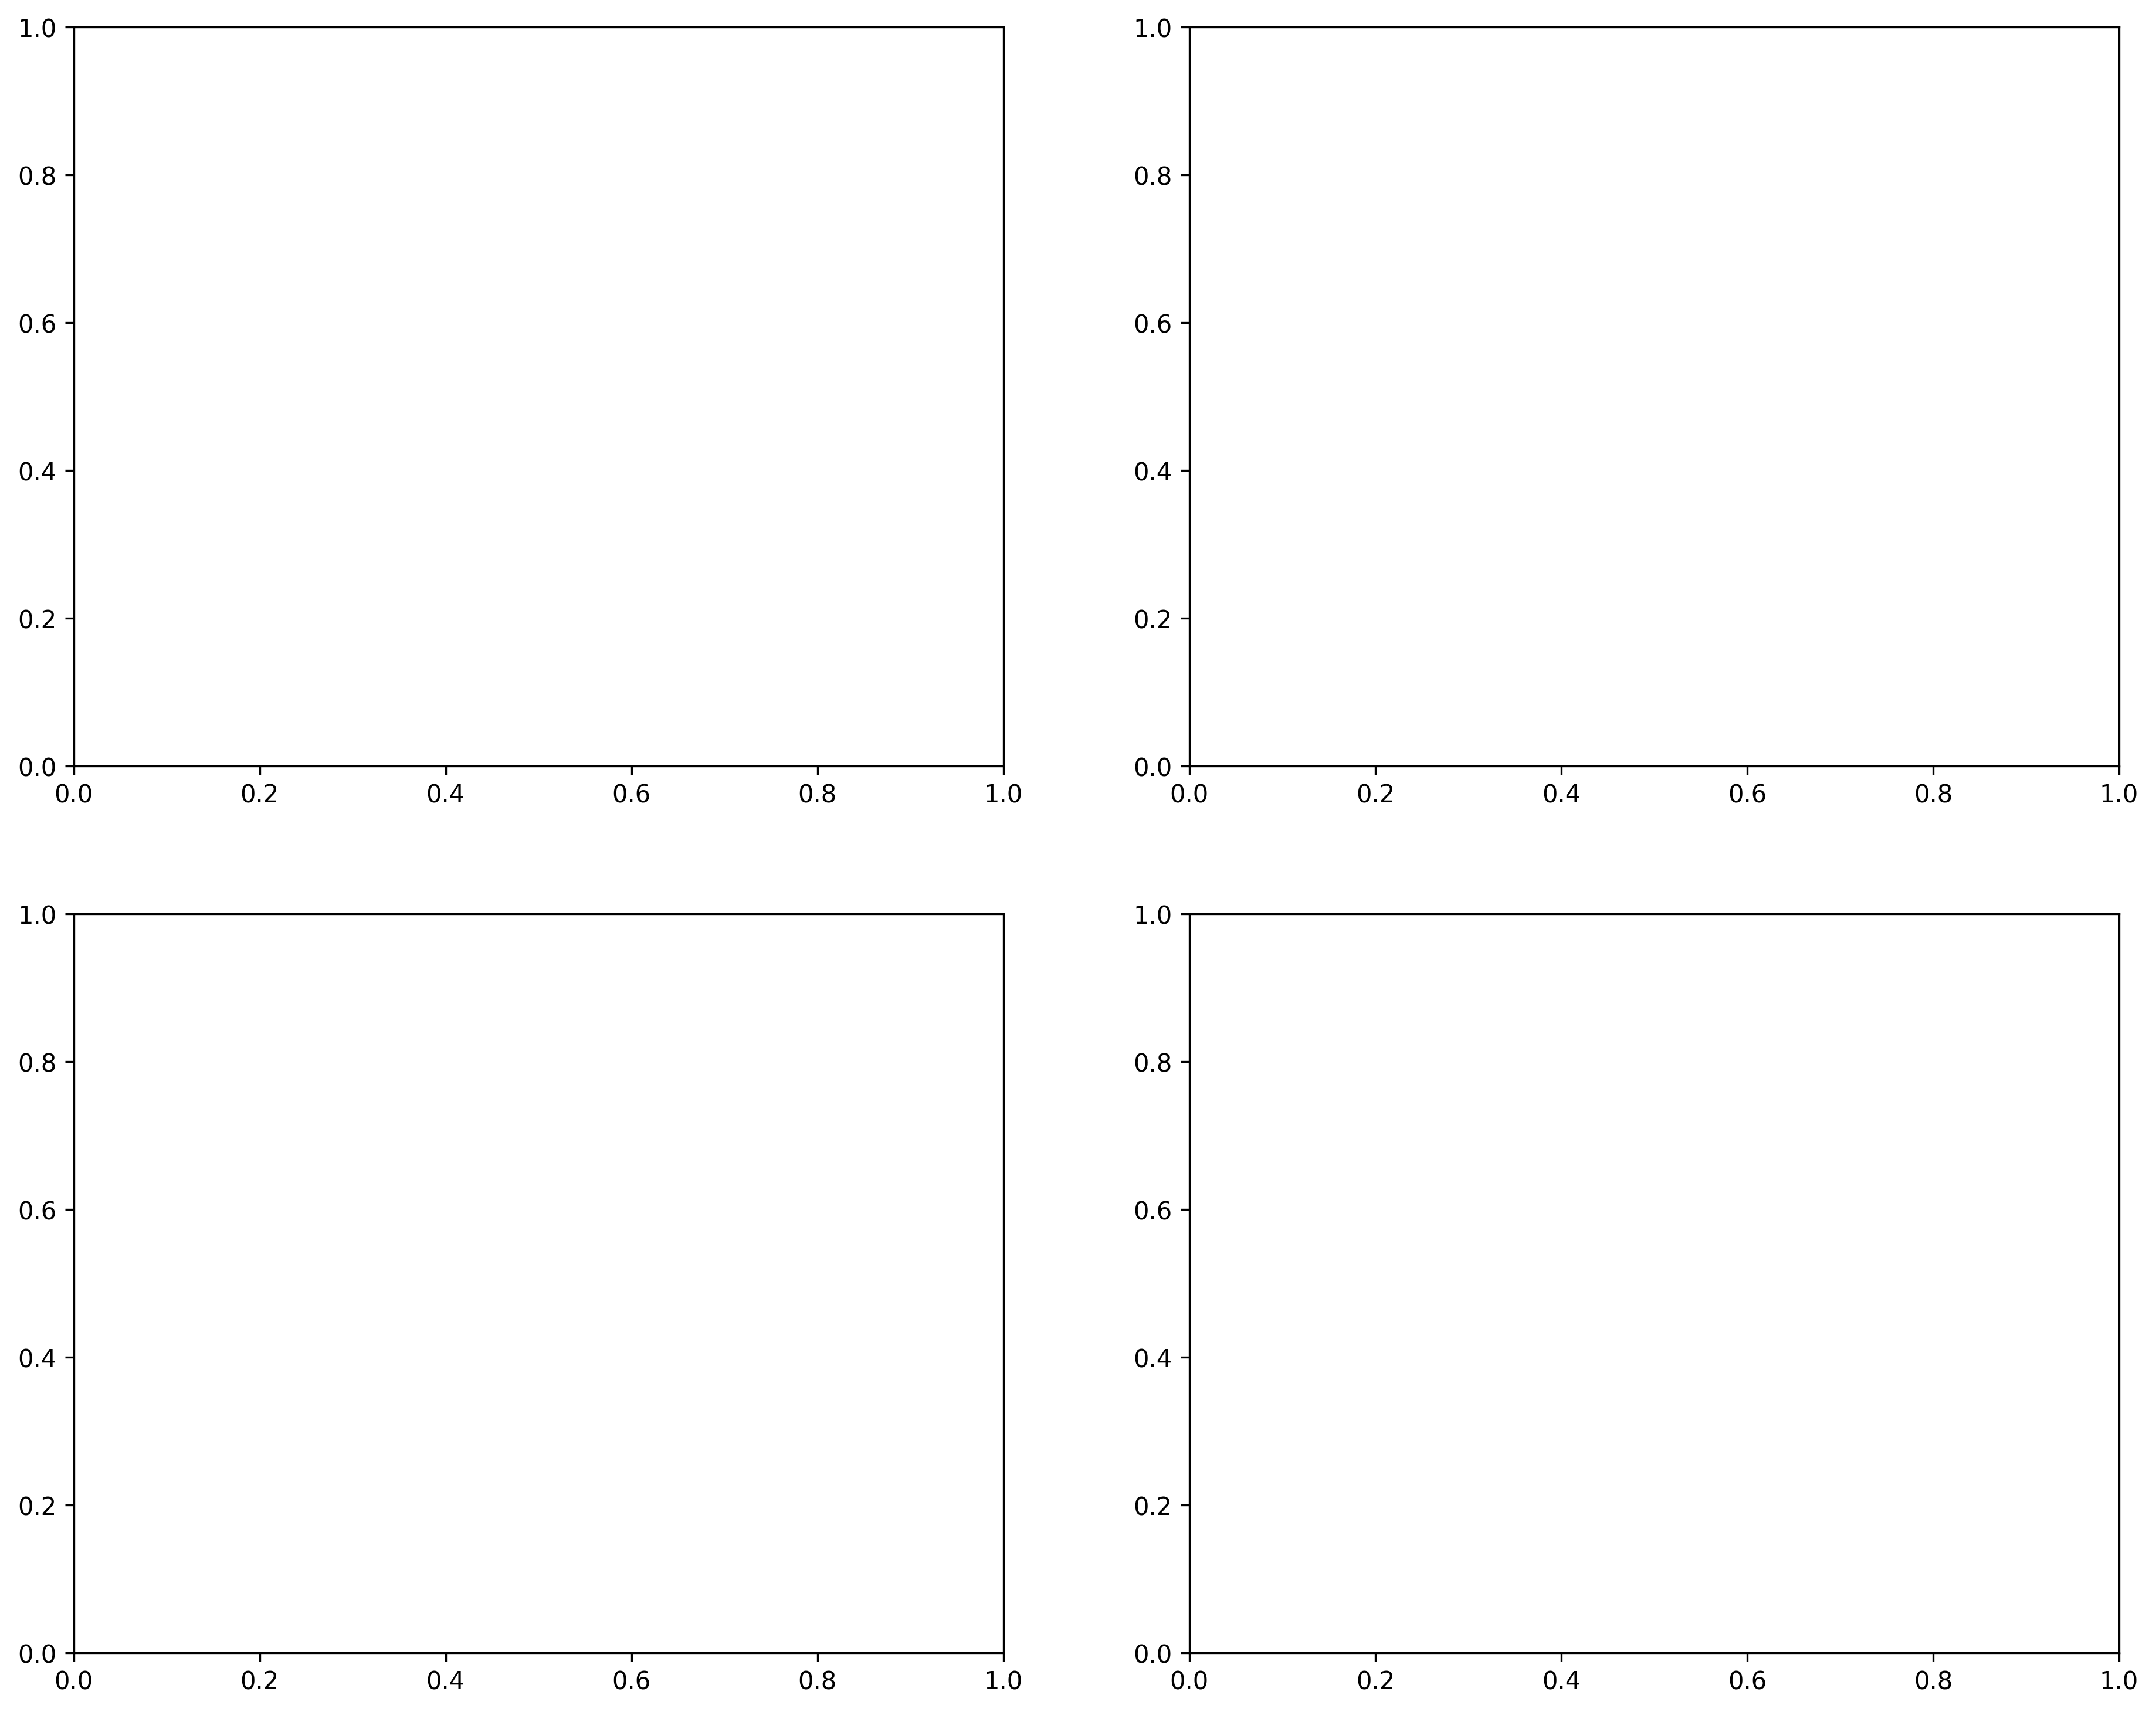

In [ ]:
from matplotlib import pyplot as plt
s = 0.5
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
ax = ax.flatten()
titles= ['No Shift', 'Separate Astro + Flux', 'Joint Astro + Flux']
ax[0].imshow(cat770.sci, origin='lower', cmap='gray', vmin=-s, vmax=s)
for i in range(3):
    if residual[i] is None:
        ax[i+1].axis('off')
        continue
    ax[i+1].imshow(residual[i], origin='lower', cmap='gray', vmin=-s, vmax=s)
    ax[i+1].set_title(titles[i])
plt.tight_layout()

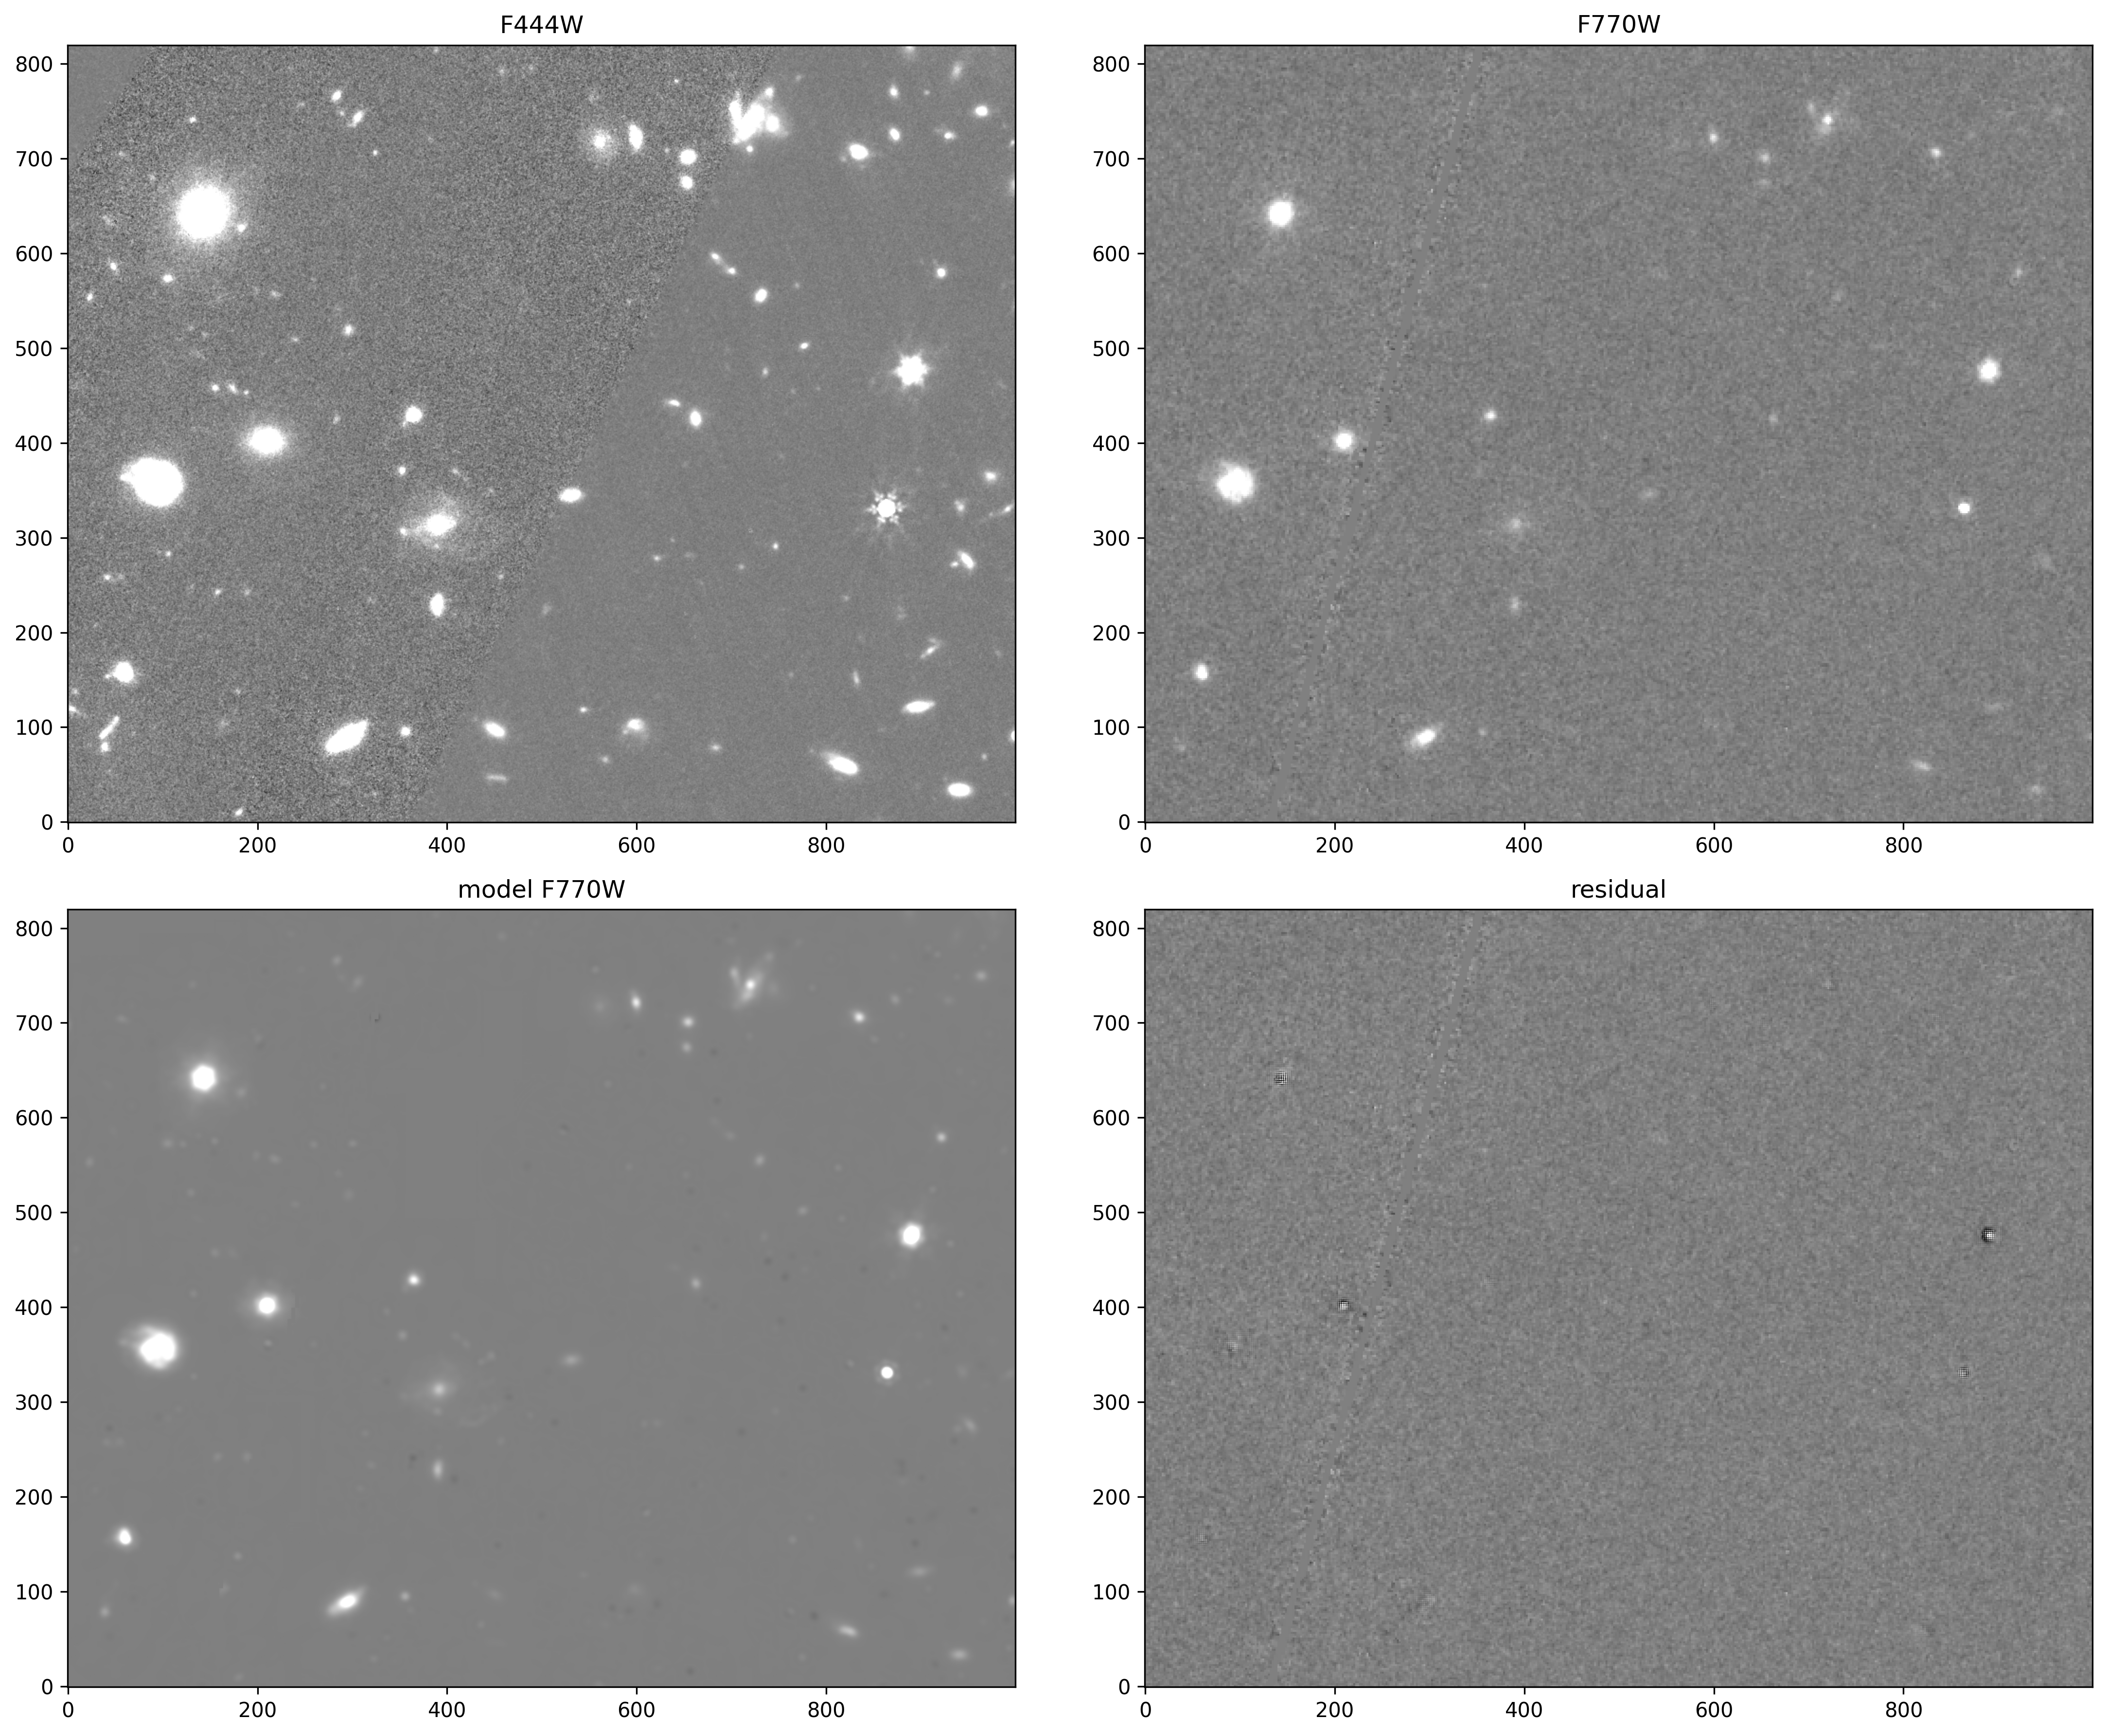

In [9]:
from matplotlib import pyplot as plt
img = [cat444.sci*5, cat770.sci, cat770.sci - residual[1], residual[1]] 
titles = ['F444W', 'F770W', 'model F770W', 'residual']
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
ax = ax.flatten()
for i in range(4):
    ax[i].imshow(img[i], origin='lower', cmap='gray', vmin=-1, vmax=1)
    ax[i].set_title(f'{titles[i]}')
plt.tight_layout() 